In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
print("Finished")

Finished


In [2]:
# Number of crossing points on the chessboard to detect
nx = 9 # Num of corners in a row
ny = 6 # Num of corners in a column

# images array stores all the calibration images
images = glob.glob("camera_cal/calibration*.jpg")

# Arrays to store object and image points from all images
objpoints = [] #3D points
imgpoints = [] #2D points

# Generate object points
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

print("Finished")

Finished


Finished


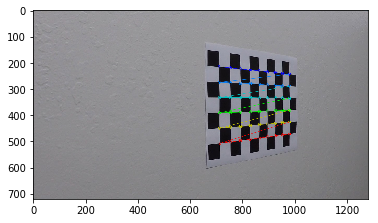

In [3]:
#Loop to calibrate all images
for fname in images: 
    #read in the image from array
    img = mpimg.imread(fname)
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Find Chessboard Corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If corners found, add object and image points
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
print("Finished")

Finished


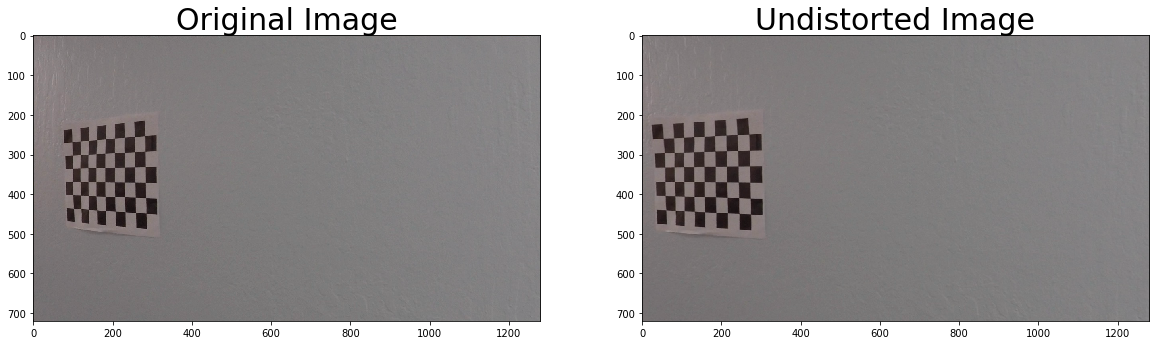

In [4]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/test_image.jpg')
original_image = img
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

print("Finished")

Finished


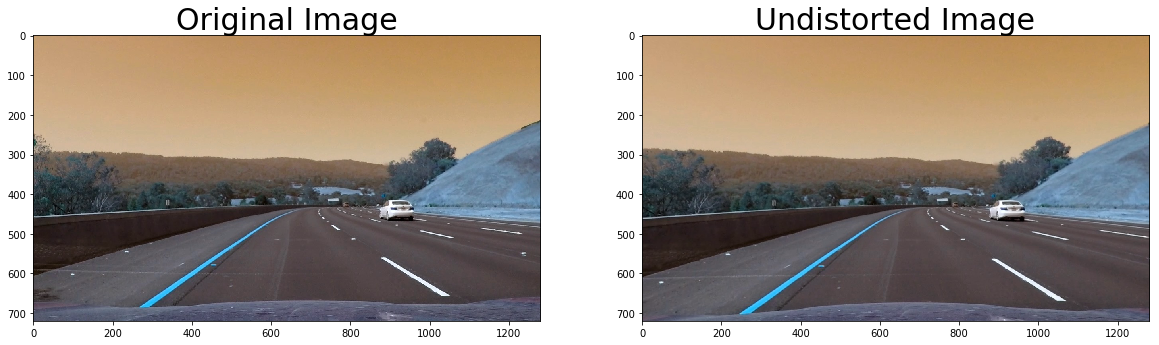

In [5]:
#Apply undistort to a sample image from the road
img_sample = cv2.imread("test_images/test3.jpg")

undist_img = cv2.undistort(img_sample, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_sample)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)
print("Finished")

In [6]:
#Read in image
image = undist_img
print("Finished")

Finished


In [7]:
#Apply absolute Sobel Threshold method
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary
print("Finished")

Finished


In [8]:
#Apply Magnitude Sobel Threshold method
def magnitude_thresh(img, sobel_kernel, mag_thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output
print("Finished")

Finished


In [9]:
#Apply Direction Sobel Threshold method
def dir_threshold(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    return binary_output
print("Finished")

Finished


In [10]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
#gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 100))
#grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 100))
#mag_binary = magnitude_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
#dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(150, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(70, 200))
mag_binary = magnitude_thresh(image, sobel_kernel=ksize, mag_thresh=(70, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.1, 1.5))

# Combine thresholds
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

print("Finished")

Finished


Finished


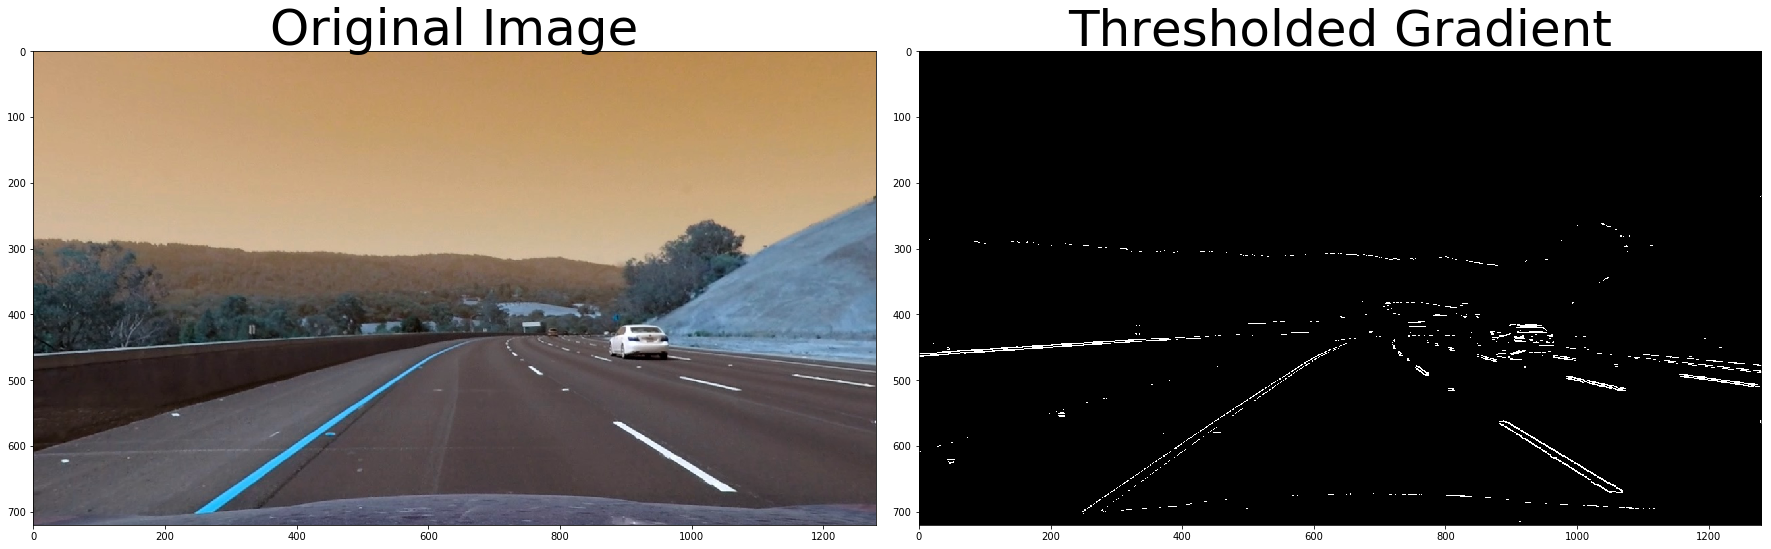

In [11]:
#Display image from the Absolute Sobel Method
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grady, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("Finished")

Finished


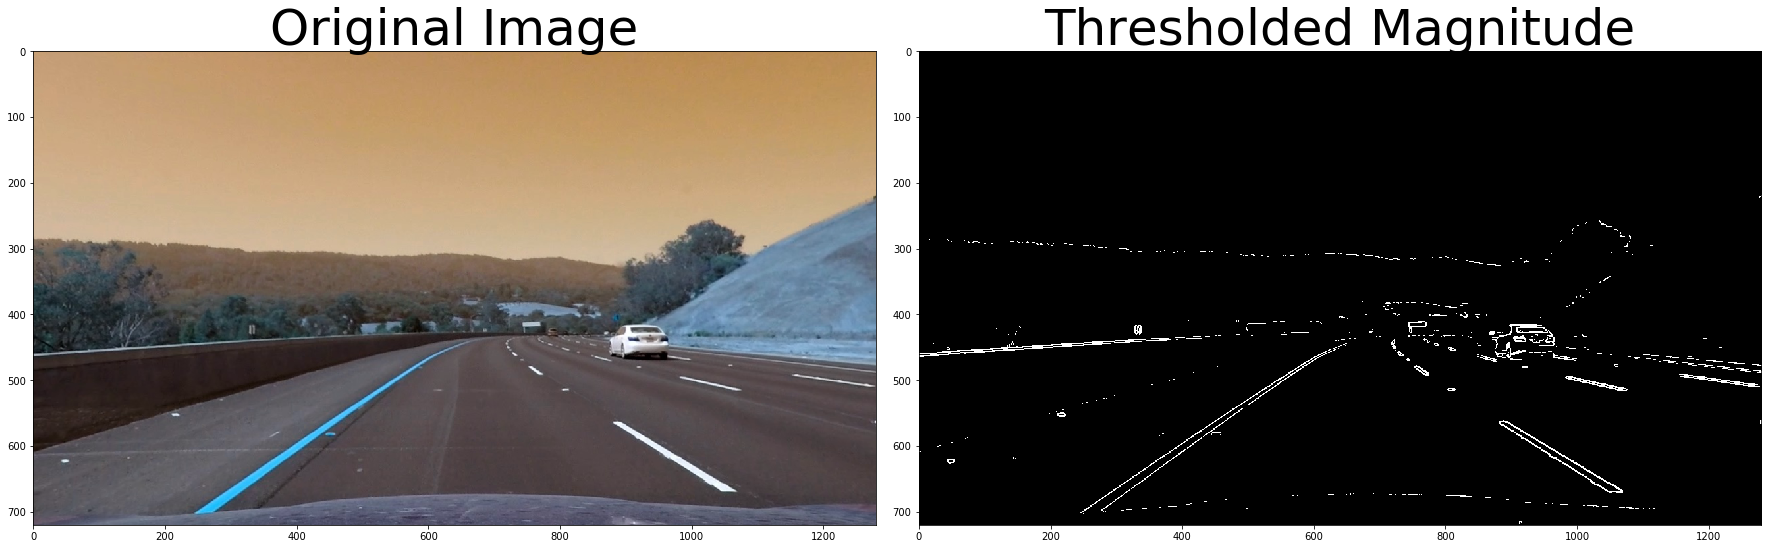

In [12]:
#Display image from the Magnitude Sobel Method
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("Finished")

Finished


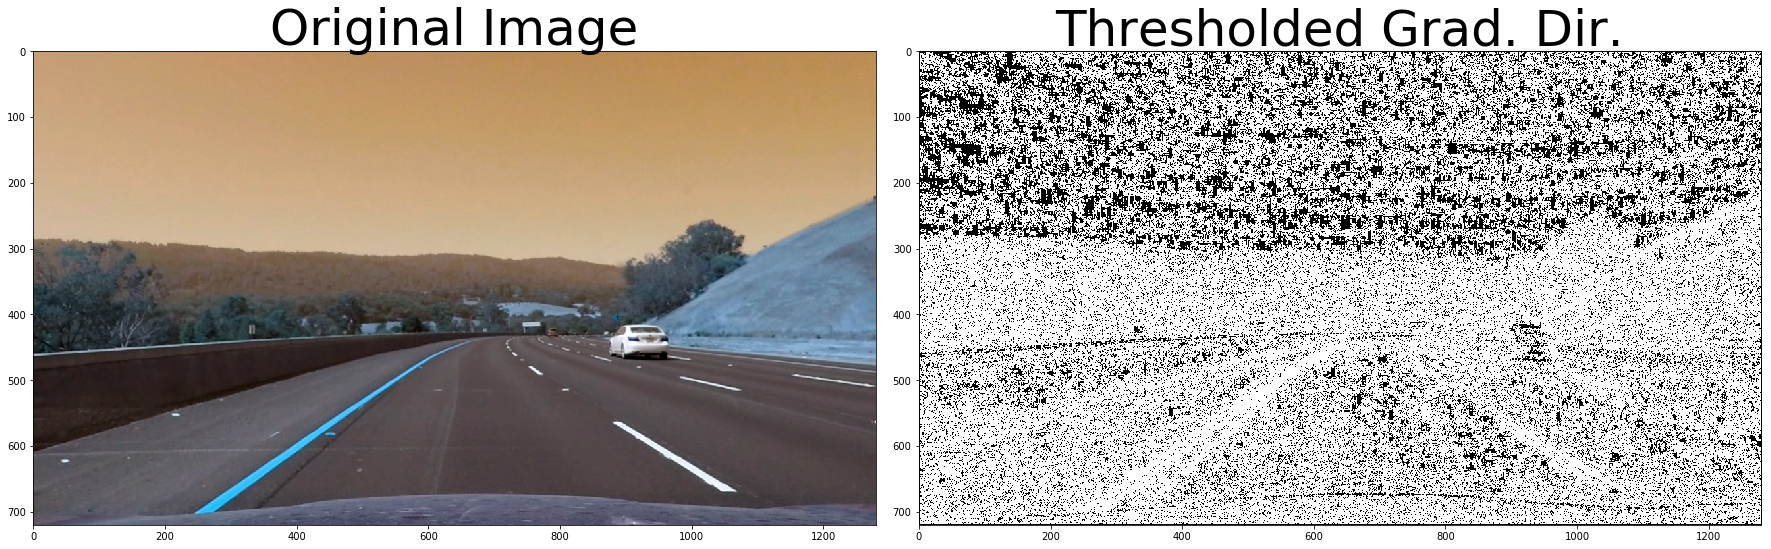

In [13]:
#Display image from the Direction Sobel Method
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("Finished")

Finished


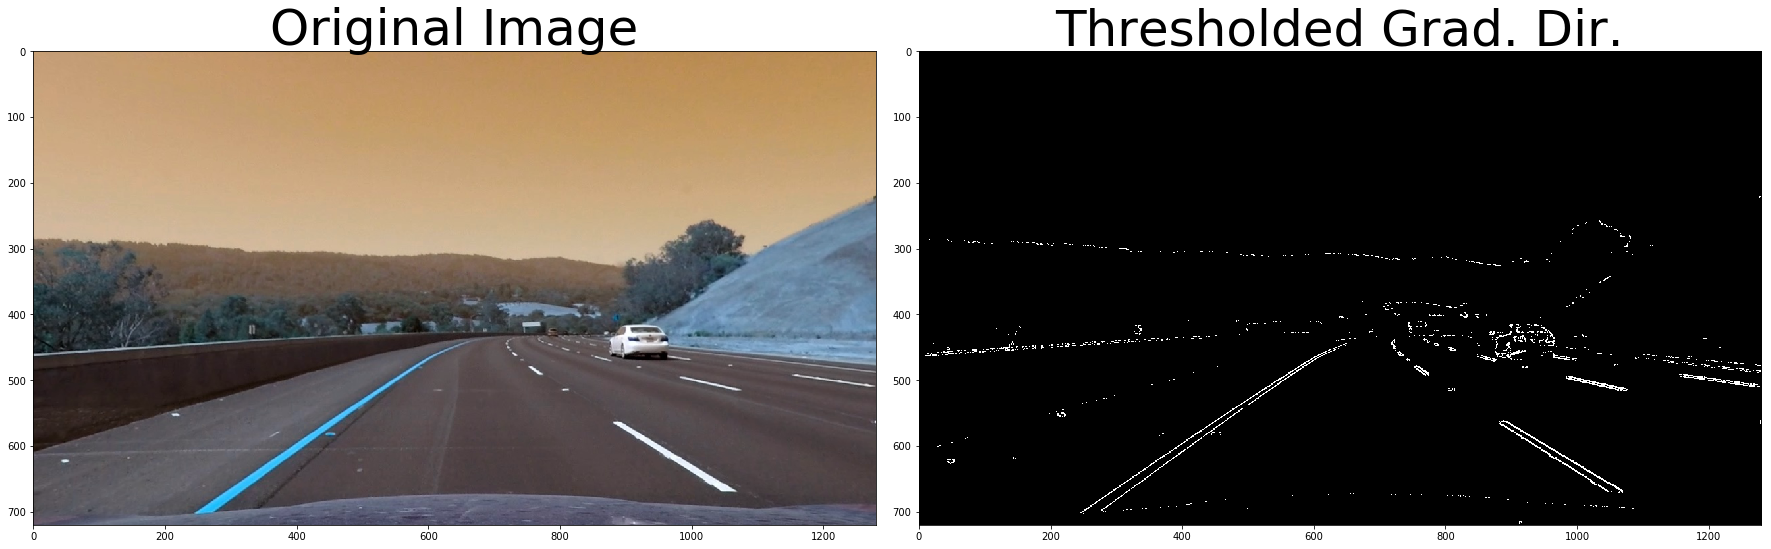

In [14]:
#Combine all the methods
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("Finished")

In [15]:
def test_threshold(img):
    # Convert image to appropriate channels
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]  

    #For the L channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 215) & (l_channel <= 255)] = 1
    
    # For the B channel
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= 145) & (b_channel <= 200)] = 1

    #Combine the two images
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    return combined_binary

print("Finished")

Finished


Finished


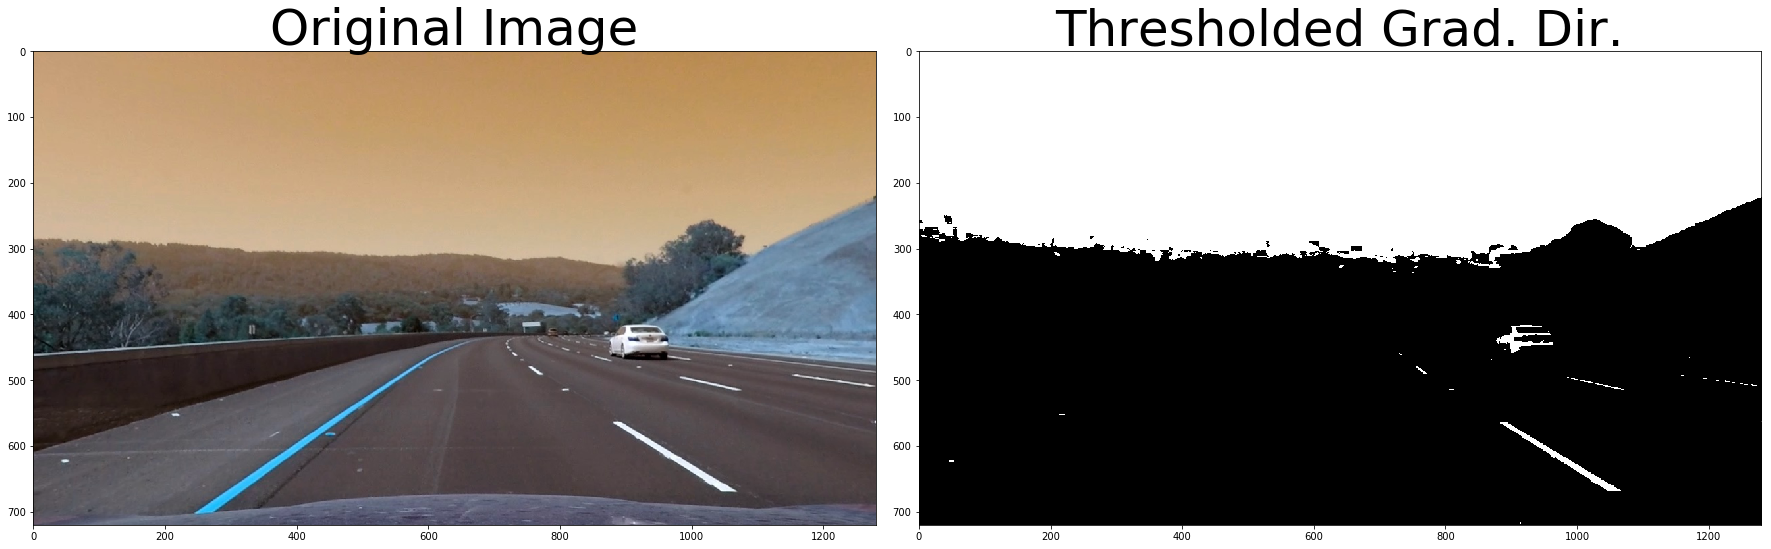

In [16]:
#Display the test method threshold
test_binary = test_threshold(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("Finished")

In [17]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):   
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[490, 482],[810, 482],
                     [1250, 720],[40, 720]])
    #src = np.float32([[590, 390],[675, 390],
      #               [1100, 700],[300, 700]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

print("Finished")

Finished


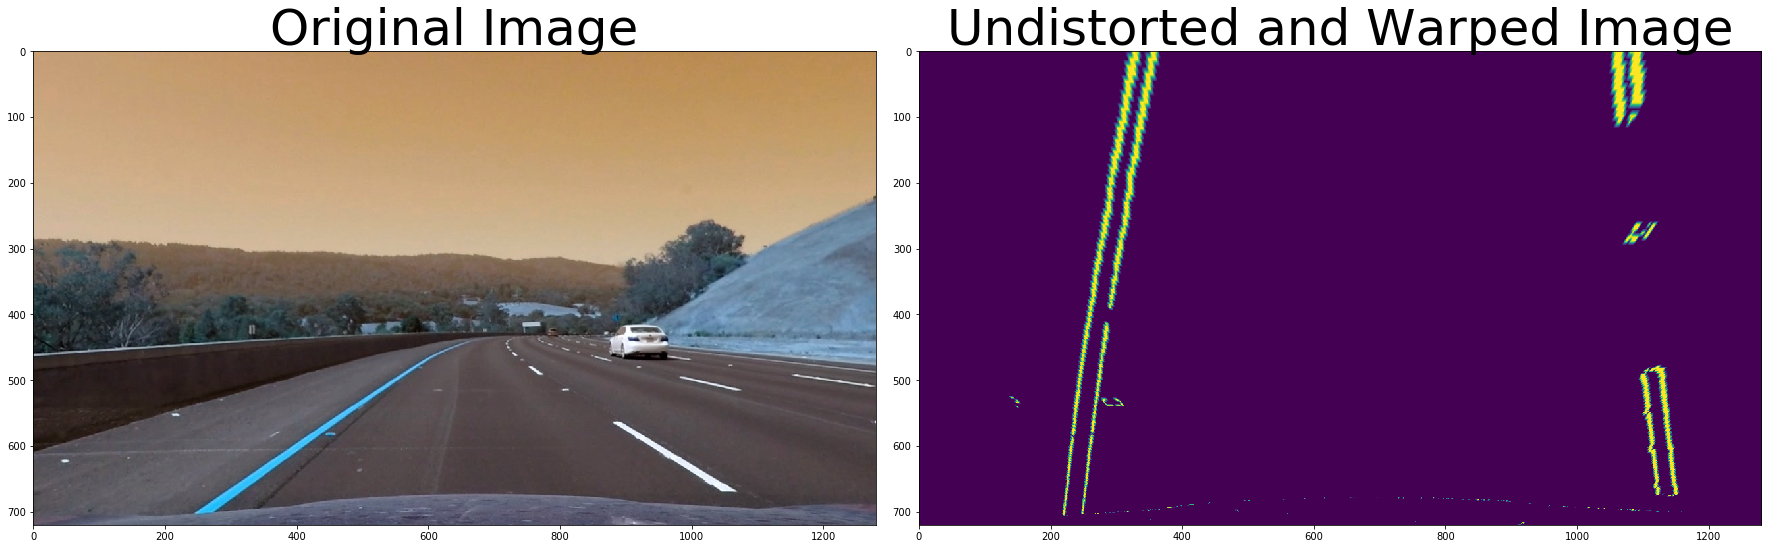

In [18]:
top_down, perspective_M = corners_unwarp(combined, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [19]:
binary_warped = top_down

In [20]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


(720, 0)

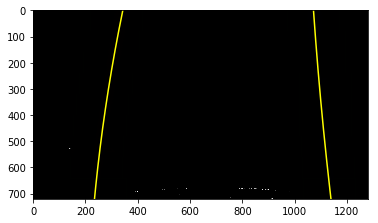

In [21]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

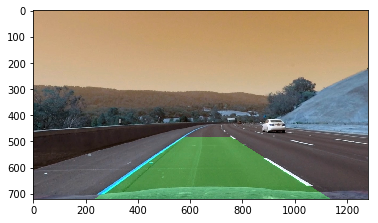

In [22]:
# Create an image to draw the lines on
src = np.float32([[490, 482],[810, 482],
                  [1250, 720],[40, 720]])
dst = np.float32([[0, 0], [1280, 0], 
                  [1250, 720],[40, 720]])
warped = combined
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
plt.imshow(result)

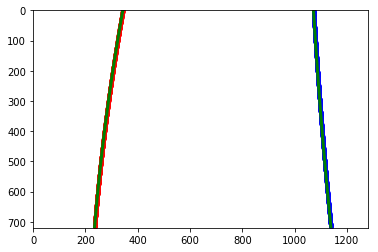

In [23]:

# Generate some fake data to represent lane-line pixels
#ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = left_fitx
rightx = right_fitx


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


In [24]:

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48


6562.85715814 15486.3441275


In [25]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 15/720 # meters per pixel in y dimension
xm_per_pix = 3.7/850 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


646.055364035 m 1514.65269337 m


In [26]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [27]:
#pipeline:


import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


with open("camera_cal/wide_dist_pickle.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]


prev_righty = None
prev_rightx = None

def processing_pipeline(file):
    global prev_righty
    global prev_rightx
    
    img_size = (file.shape[1], file.shape[0])
    undist = cv2.undistort(file, mtx, dist, None, mtx)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements



    test_binary = test_threshold(undist)
    
    top_down, perspective_M = corners_unwarp(test_binary, nx, ny, mtx, dist)
    
    binary_warped = top_down
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    if righty.size == 0:
        righty = prev_righty
        rightx = prev_rightx
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    prev_righty = righty
    prev_rightx = rightx
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    
    
    
    # Create an image to draw the lines on
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                      [1250, 720],[40, 720]])
    warped = combined
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    print(color_warp.shape)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (file.shape[1], file.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    
    
    
    
    
    
    
    

    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = left_fitx
    rightx = right_fitx


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    
    
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 15/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/850 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #Printing the curvature
    curvature = (left_curverad + right_curverad) / 2    
    cv2.putText(result, 'Curvature Radius {}(m)'.format(curvature), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255))
    
    center = (right_fitx[-1]+ left_fitx[-1])/2
    dist_center = abs((640 - center)*3.7/850) 
    if center > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(dist_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255))
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(dist_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255))
    
    return result
    
print("Finished")

Finished


In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
output = "project_output_colour.mp4"
clip3 = VideoFileClip("project_video.mp4")#.subclip(38,42)
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip3.fl_image(processing_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

(720, 1280, 3)
[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


  0%|          | 1/1261 [00:00<02:10,  9.68it/s]

(720, 1280, 3)
(720, 1280, 3)


  0%|          | 3/1261 [00:00<02:08,  9.75it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  1%|          | 7/1261 [00:00<02:02, 10.27it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  1%|          | 9/1261 [00:00<02:02, 10.25it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  1%|          | 11/1261 [00:01<02:01, 10.33it/s]

(720, 1280, 3)
(720, 1280, 3)


  1%|          | 13/1261 [00:01<01:59, 10.44it/s]

(720, 1280, 3)


  1%|          | 15/1261 [00:01<01:58, 10.54it/s]

(720, 1280, 3)
(720, 1280, 3)


  1%|▏         | 17/1261 [00:01<01:56, 10.65it/s]

(720, 1280, 3)


  2%|▏         | 19/1261 [00:01<01:54, 10.81it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  2%|▏         | 21/1261 [00:01<01:55, 10.78it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  2%|▏         | 23/1261 [00:02<01:55, 10.74it/s]

(720, 1280, 3)
(720, 1280, 3)


  2%|▏         | 25/1261 [00:02<01:56, 10.58it/s]

(720, 1280, 3)


  2%|▏         | 27/1261 [00:02<01:56, 10.59it/s]

(720, 1280, 3)
(720, 1280, 3)


  2%|▏         | 29/1261 [00:02<01:55, 10.71it/s]

(720, 1280, 3)


  2%|▏         | 31/1261 [00:02<01:54, 10.72it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  3%|▎         | 33/1261 [00:03<01:54, 10.77it/s]

(720, 1280, 3)
(720, 1280, 3)


  3%|▎         | 35/1261 [00:03<01:53, 10.84it/s]

(720, 1280, 3)


  3%|▎         | 37/1261 [00:03<01:51, 10.94it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  3%|▎         | 39/1261 [00:03<01:51, 10.96it/s]

(720, 1280, 3)
(720, 1280, 3)


  3%|▎         | 41/1261 [00:03<01:51, 10.98it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  4%|▎         | 45/1261 [00:04<01:56, 10.48it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  4%|▎         | 47/1261 [00:04<01:55, 10.53it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  4%|▍         | 51/1261 [00:04<01:55, 10.48it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  4%|▍         | 53/1261 [00:04<01:56, 10.40it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  5%|▍         | 57/1261 [00:05<01:57, 10.24it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  5%|▍         | 59/1261 [00:05<01:57, 10.25it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  5%|▍         | 63/1261 [00:05<01:55, 10.34it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  5%|▌         | 65/1261 [00:06<01:56, 10.23it/s]

(720, 1280, 3)
(720, 1280, 3)


  5%|▌         | 67/1261 [00:06<01:58, 10.05it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  6%|▌         | 71/1261 [00:06<01:58, 10.08it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  6%|▌         | 73/1261 [00:06<01:58, 10.01it/s]

(720, 1280, 3)
(720, 1280, 3)


  6%|▌         | 76/1261 [00:07<02:00,  9.82it/s]

(720, 1280, 3)
(720, 1280, 3)


  6%|▌         | 78/1261 [00:07<02:05,  9.41it/s]

(720, 1280, 3)
(720, 1280, 3)


  6%|▋         | 79/1261 [00:07<02:05,  9.40it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  7%|▋         | 83/1261 [00:08<02:01,  9.68it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  7%|▋         | 85/1261 [00:08<02:02,  9.63it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  7%|▋         | 89/1261 [00:08<01:59,  9.80it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  7%|▋         | 91/1261 [00:08<01:59,  9.82it/s]

(720, 1280, 3)
(720, 1280, 3)


  7%|▋         | 93/1261 [00:09<01:59,  9.78it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  8%|▊         | 97/1261 [00:09<01:57,  9.93it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  8%|▊         | 99/1261 [00:09<02:00,  9.60it/s]

(720, 1280, 3)
(720, 1280, 3)


  8%|▊         | 102/1261 [00:09<01:59,  9.71it/s]

(720, 1280, 3)
(720, 1280, 3)


  8%|▊         | 104/1261 [00:10<02:03,  9.34it/s]

(720, 1280, 3)
(720, 1280, 3)


  8%|▊         | 105/1261 [00:10<02:04,  9.30it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  9%|▊         | 109/1261 [00:10<01:58,  9.73it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  9%|▉         | 111/1261 [00:10<01:57,  9.77it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  9%|▉         | 115/1261 [00:11<01:58,  9.65it/s]

(720, 1280, 3)
(720, 1280, 3)


  9%|▉         | 117/1261 [00:11<01:58,  9.66it/s]

(720, 1280, 3)
(720, 1280, 3)


  9%|▉         | 119/1261 [00:11<02:08,  8.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 10%|▉         | 121/1261 [00:11<02:05,  9.11it/s]

(720, 1280, 3)
(720, 1280, 3)


 10%|▉         | 123/1261 [00:12<02:03,  9.19it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 10%|▉         | 126/1261 [00:12<02:01,  9.35it/s]

(720, 1280, 3)
(720, 1280, 3)


 10%|█         | 128/1261 [00:12<01:59,  9.51it/s]

(720, 1280, 3)
(720, 1280, 3)


 10%|█         | 130/1261 [00:12<01:58,  9.56it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 11%|█         | 134/1261 [00:13<01:54,  9.81it/s]

(720, 1280, 3)
(720, 1280, 3)


 11%|█         | 135/1261 [00:13<01:58,  9.50it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 11%|█         | 139/1261 [00:13<01:54,  9.76it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 11%|█▏        | 142/1261 [00:14<01:54,  9.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 11%|█▏        | 144/1261 [00:14<01:54,  9.72it/s]

(720, 1280, 3)
(720, 1280, 3)


 12%|█▏        | 146/1261 [00:14<01:55,  9.67it/s]

(720, 1280, 3)
(720, 1280, 3)


 12%|█▏        | 148/1261 [00:14<01:55,  9.63it/s]

(720, 1280, 3)
(720, 1280, 3)


 12%|█▏        | 149/1261 [00:14<01:57,  9.50it/s]

(720, 1280, 3)
(720, 1280, 3)


 12%|█▏        | 151/1261 [00:15<01:55,  9.61it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 12%|█▏        | 155/1261 [00:15<01:53,  9.75it/s]

(720, 1280, 3)
(720, 1280, 3)


 12%|█▏        | 157/1261 [00:15<01:56,  9.44it/s]

(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 159/1261 [00:15<01:55,  9.55it/s]

(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 161/1261 [00:16<02:00,  9.11it/s]

(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 163/1261 [00:16<01:57,  9.38it/s]

(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 165/1261 [00:16<01:58,  9.21it/s]

(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 167/1261 [00:16<01:56,  9.37it/s]

(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 169/1261 [00:16<01:54,  9.51it/s]

(720, 1280, 3)
(720, 1280, 3)


 14%|█▎        | 171/1261 [00:17<01:56,  9.37it/s]

(720, 1280, 3)
(720, 1280, 3)


 14%|█▎        | 173/1261 [00:17<02:01,  8.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 14%|█▍        | 175/1261 [00:17<01:57,  9.25it/s]

(720, 1280, 3)
(720, 1280, 3)


 14%|█▍        | 177/1261 [00:17<01:54,  9.50it/s]

(720, 1280, 3)
(720, 1280, 3)


 14%|█▍        | 179/1261 [00:18<01:52,  9.66it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 14%|█▍        | 181/1261 [00:18<01:52,  9.60it/s]

(720, 1280, 3)
(720, 1280, 3)


 15%|█▍        | 184/1261 [00:18<01:56,  9.24it/s]

(720, 1280, 3)
(720, 1280, 3)


 15%|█▍        | 186/1261 [00:18<01:52,  9.52it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 15%|█▍        | 189/1261 [00:19<01:50,  9.68it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 15%|█▌        | 192/1261 [00:19<01:48,  9.83it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 15%|█▌        | 195/1261 [00:19<01:47,  9.95it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 16%|█▌        | 197/1261 [00:19<01:47,  9.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 16%|█▌        | 199/1261 [00:20<01:48,  9.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 16%|█▌        | 201/1261 [00:20<01:47,  9.82it/s]

(720, 1280, 3)
(720, 1280, 3)


 16%|█▌        | 204/1261 [00:20<01:48,  9.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 16%|█▋        | 205/1261 [00:20<01:49,  9.62it/s]

(720, 1280, 3)
(720, 1280, 3)


 16%|█▋        | 207/1261 [00:20<01:49,  9.65it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 211/1261 [00:21<01:47,  9.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 213/1261 [00:21<01:46,  9.80it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 215/1261 [00:21<01:46,  9.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 217/1261 [00:21<01:46,  9.81it/s]

(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 220/1261 [00:22<01:47,  9.67it/s]

(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 222/1261 [00:22<01:52,  9.22it/s]

(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 224/1261 [00:22<01:54,  9.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 226/1261 [00:22<01:54,  9.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 228/1261 [00:23<01:57,  8.82it/s]

(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 230/1261 [00:23<01:55,  8.96it/s]

(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 232/1261 [00:23<01:49,  9.41it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 19%|█▊        | 235/1261 [00:23<01:46,  9.67it/s]

(720, 1280, 3)
(720, 1280, 3)


 19%|█▊        | 236/1261 [00:23<01:47,  9.54it/s]

(720, 1280, 3)
(720, 1280, 3)


 19%|█▉        | 240/1261 [00:24<01:48,  9.39it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 19%|█▉        | 241/1261 [00:24<01:47,  9.50it/s]

(720, 1280, 3)
(720, 1280, 3)


 19%|█▉        | 243/1261 [00:24<01:46,  9.52it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 20%|█▉        | 247/1261 [00:25<01:43,  9.81it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 20%|█▉        | 249/1261 [00:25<01:41,  9.95it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 20%|██        | 253/1261 [00:25<01:40, 10.06it/s]

(720, 1280, 3)
(720, 1280, 3)


 20%|██        | 255/1261 [00:25<01:41,  9.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 20%|██        | 257/1261 [00:26<01:47,  9.31it/s]

(720, 1280, 3)
(720, 1280, 3)


 20%|██        | 258/1261 [00:26<01:49,  9.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 21%|██        | 260/1261 [00:26<01:47,  9.35it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 21%|██        | 264/1261 [00:26<01:41,  9.84it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 21%|██        | 266/1261 [00:26<01:40,  9.92it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 21%|██▏       | 270/1261 [00:27<01:38, 10.06it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 22%|██▏       | 272/1261 [00:27<01:38, 10.09it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 22%|██▏       | 276/1261 [00:27<01:37, 10.15it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 22%|██▏       | 278/1261 [00:28<01:36, 10.16it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 22%|██▏       | 282/1261 [00:28<01:35, 10.22it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 23%|██▎       | 284/1261 [00:28<01:35, 10.24it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 23%|██▎       | 288/1261 [00:29<01:35, 10.22it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 23%|██▎       | 290/1261 [00:29<01:35, 10.21it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 23%|██▎       | 294/1261 [00:29<01:34, 10.25it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 23%|██▎       | 296/1261 [00:29<01:33, 10.29it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 24%|██▍       | 300/1261 [00:30<01:33, 10.33it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 24%|██▍       | 302/1261 [00:30<01:33, 10.25it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 24%|██▍       | 306/1261 [00:30<01:33, 10.25it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 24%|██▍       | 308/1261 [00:31<01:32, 10.28it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 25%|██▍       | 312/1261 [00:31<01:32, 10.29it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 25%|██▍       | 314/1261 [00:31<01:32, 10.28it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 25%|██▌       | 318/1261 [00:32<01:33, 10.10it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 25%|██▌       | 320/1261 [00:32<01:32, 10.19it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 324/1261 [00:32<01:31, 10.21it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 326/1261 [00:32<01:31, 10.26it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 330/1261 [00:33<01:30, 10.24it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 26%|██▋       | 332/1261 [00:33<01:31, 10.19it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 336/1261 [00:33<01:30, 10.25it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 338/1261 [00:34<01:30, 10.19it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 342/1261 [00:34<01:31, 10.05it/s]

(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 344/1261 [00:34<01:32,  9.92it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 346/1261 [00:34<01:31, 10.03it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 350/1261 [00:35<01:30, 10.11it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 352/1261 [00:35<01:29, 10.13it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 356/1261 [00:35<01:28, 10.19it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 358/1261 [00:36<01:29, 10.08it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 29%|██▊       | 362/1261 [00:36<01:28, 10.18it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 29%|██▉       | 364/1261 [00:36<01:27, 10.30it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 29%|██▉       | 368/1261 [00:36<01:26, 10.32it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 29%|██▉       | 370/1261 [00:37<01:26, 10.33it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 30%|██▉       | 374/1261 [00:37<01:26, 10.24it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 30%|██▉       | 376/1261 [00:37<01:26, 10.23it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 30%|███       | 380/1261 [00:38<01:26, 10.20it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 30%|███       | 382/1261 [00:38<01:25, 10.25it/s]

(720, 1280, 3)
(720, 1280, 3)


 30%|███       | 384/1261 [00:38<01:27, 10.01it/s]

(720, 1280, 3)
(720, 1280, 3)


 31%|███       | 387/1261 [00:38<01:28,  9.92it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 31%|███       | 389/1261 [00:39<01:26, 10.03it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 31%|███       | 393/1261 [00:39<01:26, 10.00it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 31%|███▏      | 395/1261 [00:39<01:26, 10.05it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 399/1261 [00:40<01:25, 10.05it/s]

(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 401/1261 [00:40<01:25, 10.06it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 405/1261 [00:40<01:25, 10.02it/s]

(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 407/1261 [00:40<01:24, 10.06it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 409/1261 [00:41<01:25,  9.96it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 413/1261 [00:41<01:24, 10.04it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 416/1261 [00:41<01:29,  9.45it/s]

(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 418/1261 [00:41<01:28,  9.49it/s]

(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 419/1261 [00:42<01:28,  9.56it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 34%|███▎      | 423/1261 [00:42<01:25,  9.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 34%|███▎      | 425/1261 [00:42<01:25,  9.82it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 427/1261 [00:42<01:24,  9.90it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 431/1261 [00:43<01:22, 10.00it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 433/1261 [00:43<01:22,  9.98it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 35%|███▍      | 437/1261 [00:43<01:21, 10.08it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 35%|███▍      | 439/1261 [00:44<01:21, 10.10it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 35%|███▌      | 443/1261 [00:44<01:20, 10.12it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 35%|███▌      | 445/1261 [00:44<01:20, 10.13it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 36%|███▌      | 449/1261 [00:45<01:19, 10.20it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 36%|███▌      | 451/1261 [00:45<01:19, 10.19it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 36%|███▌      | 455/1261 [00:45<01:19, 10.11it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 36%|███▋      | 458/1261 [00:45<01:20,  9.96it/s]

(720, 1280, 3)
(720, 1280, 3)


 36%|███▋      | 459/1261 [00:46<01:23,  9.57it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 463/1261 [00:46<01:22,  9.63it/s]

(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 465/1261 [00:46<01:21,  9.77it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 468/1261 [00:47<01:21,  9.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 470/1261 [00:47<01:36,  8.21it/s]

(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 472/1261 [00:47<01:39,  7.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 474/1261 [00:47<01:35,  8.26it/s]

(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 476/1261 [00:48<01:33,  8.42it/s]

(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 477/1261 [00:48<01:35,  8.24it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 481/1261 [00:48<01:28,  8.78it/s]

(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 483/1261 [00:48<01:25,  9.11it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 485/1261 [00:48<01:22,  9.38it/s]

(720, 1280, 3)
(720, 1280, 3)


 39%|███▊      | 487/1261 [00:49<01:21,  9.48it/s]

(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 489/1261 [00:49<01:21,  9.48it/s]

(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 491/1261 [00:49<01:20,  9.56it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 495/1261 [00:49<01:17,  9.92it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 497/1261 [00:50<01:18,  9.68it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 40%|███▉      | 501/1261 [00:50<01:17,  9.80it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 40%|███▉      | 503/1261 [00:50<01:16,  9.92it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 40%|████      | 507/1261 [00:51<01:15, 10.01it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 40%|████      | 509/1261 [00:51<01:14, 10.05it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 41%|████      | 513/1261 [00:51<01:13, 10.11it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 41%|████      | 515/1261 [00:51<01:13, 10.12it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 41%|████      | 519/1261 [00:52<01:12, 10.21it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 41%|████▏     | 521/1261 [00:52<01:12, 10.18it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 42%|████▏     | 525/1261 [00:52<01:13, 10.07it/s]

(720, 1280, 3)
(720, 1280, 3)


 42%|████▏     | 527/1261 [00:53<01:13, 10.00it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 42%|████▏     | 529/1261 [00:53<01:13,  9.98it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 42%|████▏     | 533/1261 [00:53<01:12, 10.09it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 536/1261 [00:54<01:13,  9.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 538/1261 [00:54<01:14,  9.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 540/1261 [00:54<01:15,  9.56it/s]

(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 542/1261 [00:54<01:14,  9.68it/s]

(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 544/1261 [00:54<01:18,  9.10it/s]

(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 545/1261 [00:55<01:17,  9.25it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 44%|████▎     | 549/1261 [00:55<01:12,  9.79it/s]

(720, 1280, 3)
(720, 1280, 3)


 44%|████▎     | 551/1261 [00:55<01:13,  9.62it/s]

(720, 1280, 3)
(720, 1280, 3)


 44%|████▍     | 552/1261 [00:55<01:15,  9.42it/s]

(720, 1280, 3)
(720, 1280, 3)


 44%|████▍     | 555/1261 [00:56<01:15,  9.34it/s]

(720, 1280, 3)
(720, 1280, 3)


 44%|████▍     | 556/1261 [00:56<01:17,  9.12it/s]

(720, 1280, 3)
(720, 1280, 3)


 44%|████▍     | 559/1261 [00:56<01:14,  9.40it/s]

(720, 1280, 3)
(720, 1280, 3)


 44%|████▍     | 561/1261 [00:56<01:15,  9.33it/s]

(720, 1280, 3)
(720, 1280, 3)


 45%|████▍     | 563/1261 [00:56<01:15,  9.19it/s]

(720, 1280, 3)
(720, 1280, 3)


 45%|████▍     | 565/1261 [00:57<01:15,  9.26it/s]

(720, 1280, 3)
(720, 1280, 3)


 45%|████▍     | 566/1261 [00:57<01:15,  9.17it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 45%|████▌     | 570/1261 [00:57<01:12,  9.60it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 45%|████▌     | 573/1261 [00:57<01:12,  9.53it/s]

(720, 1280, 3)
(720, 1280, 3)


 46%|████▌     | 575/1261 [00:58<01:12,  9.53it/s]

(720, 1280, 3)
(720, 1280, 3)


 46%|████▌     | 576/1261 [00:58<01:12,  9.47it/s]

(720, 1280, 3)
(720, 1280, 3)


 46%|████▌     | 578/1261 [00:58<01:11,  9.51it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 46%|████▌     | 582/1261 [00:58<01:09,  9.79it/s]

(720, 1280, 3)
(720, 1280, 3)


 46%|████▋     | 584/1261 [00:59<01:11,  9.52it/s]

(720, 1280, 3)
(720, 1280, 3)


 46%|████▋     | 586/1261 [00:59<01:13,  9.23it/s]

(720, 1280, 3)
(720, 1280, 3)


 47%|████▋     | 588/1261 [00:59<01:15,  8.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 47%|████▋     | 590/1261 [00:59<01:16,  8.75it/s]

(720, 1280, 3)
(720, 1280, 3)


 47%|████▋     | 592/1261 [01:00<01:16,  8.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 47%|████▋     | 594/1261 [01:00<01:15,  8.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 47%|████▋     | 596/1261 [01:00<01:12,  9.11it/s]

(720, 1280, 3)
(720, 1280, 3)


 47%|████▋     | 598/1261 [01:00<01:12,  9.09it/s]

(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 600/1261 [01:00<01:10,  9.42it/s]

(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 601/1261 [01:00<01:10,  9.39it/s]

(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 604/1261 [01:01<01:08,  9.53it/s]

(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 606/1261 [01:01<01:16,  8.56it/s]

(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 608/1261 [01:01<01:15,  8.70it/s]

(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 610/1261 [01:02<01:15,  8.65it/s]

(720, 1280, 3)
(720, 1280, 3)


 49%|████▊     | 612/1261 [01:02<01:14,  8.67it/s]

(720, 1280, 3)
(720, 1280, 3)


 49%|████▊     | 614/1261 [01:02<01:11,  9.05it/s]

(720, 1280, 3)
(720, 1280, 3)


 49%|████▉     | 616/1261 [01:02<01:11,  9.06it/s]

(720, 1280, 3)
(720, 1280, 3)


 49%|████▉     | 618/1261 [01:02<01:08,  9.44it/s]

(720, 1280, 3)
(720, 1280, 3)


 49%|████▉     | 620/1261 [01:03<01:07,  9.53it/s]

(720, 1280, 3)
(720, 1280, 3)


 49%|████▉     | 622/1261 [01:03<01:06,  9.61it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 50%|████▉     | 625/1261 [01:03<01:05,  9.69it/s]

(720, 1280, 3)
(720, 1280, 3)


 50%|████▉     | 627/1261 [01:03<01:05,  9.72it/s]

(720, 1280, 3)
(720, 1280, 3)


 50%|████▉     | 629/1261 [01:04<01:05,  9.72it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 50%|█████     | 633/1261 [01:04<01:03,  9.87it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 50%|█████     | 635/1261 [01:04<01:03,  9.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 51%|█████     | 637/1261 [01:04<01:03,  9.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 51%|█████     | 639/1261 [01:05<01:03,  9.82it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 51%|█████     | 643/1261 [01:05<01:02,  9.93it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 51%|█████     | 645/1261 [01:05<01:01, 10.00it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 51%|█████▏    | 649/1261 [01:05<01:00, 10.10it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 52%|█████▏    | 651/1261 [01:06<01:00, 10.07it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 52%|█████▏    | 655/1261 [01:06<01:01,  9.91it/s]

(720, 1280, 3)
(720, 1280, 3)


 52%|█████▏    | 657/1261 [01:06<01:00,  9.92it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 52%|█████▏    | 659/1261 [01:07<01:01,  9.87it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 53%|█████▎    | 663/1261 [01:07<00:59, 10.07it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 53%|█████▎    | 666/1261 [01:07<00:59,  9.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 53%|█████▎    | 667/1261 [01:07<01:02,  9.57it/s]

(720, 1280, 3)
(720, 1280, 3)


 53%|█████▎    | 669/1261 [01:08<01:01,  9.66it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 53%|█████▎    | 673/1261 [01:08<00:59,  9.86it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 54%|█████▎    | 675/1261 [01:08<00:59,  9.85it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 54%|█████▍    | 679/1261 [01:09<00:58,  9.92it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 54%|█████▍    | 681/1261 [01:09<00:58,  9.96it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 54%|█████▍    | 685/1261 [01:09<00:57, 10.02it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 55%|█████▍    | 688/1261 [01:09<01:01,  9.29it/s]

(720, 1280, 3)
(720, 1280, 3)


 55%|█████▍    | 689/1261 [01:10<01:02,  9.21it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 55%|█████▍    | 692/1261 [01:10<00:59,  9.57it/s]

(720, 1280, 3)
(720, 1280, 3)


 55%|█████▌    | 694/1261 [01:10<00:58,  9.62it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 55%|█████▌    | 698/1261 [01:10<00:56, 10.02it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 56%|█████▌    | 700/1261 [01:11<00:55, 10.05it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 56%|█████▌    | 704/1261 [01:11<00:54, 10.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 56%|█████▌    | 706/1261 [01:11<00:59,  9.39it/s]

(720, 1280, 3)
(720, 1280, 3)


 56%|█████▌    | 708/1261 [01:12<01:00,  9.20it/s]

(720, 1280, 3)
(720, 1280, 3)


 56%|█████▋    | 710/1261 [01:12<01:01,  8.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 56%|█████▋    | 712/1261 [01:12<01:00,  9.04it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 714/1261 [01:12<00:59,  9.17it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 716/1261 [01:12<00:58,  9.28it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 718/1261 [01:13<00:58,  9.33it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 720/1261 [01:13<00:57,  9.37it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 722/1261 [01:13<00:57,  9.38it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 724/1261 [01:13<00:59,  9.08it/s]

(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 726/1261 [01:13<00:59,  9.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 728/1261 [01:14<01:00,  8.75it/s]

(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 730/1261 [01:14<00:59,  8.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 732/1261 [01:14<00:59,  8.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 734/1261 [01:14<00:56,  9.28it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 737/1261 [01:15<00:54,  9.53it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 59%|█████▊    | 740/1261 [01:15<00:56,  9.19it/s]

(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 742/1261 [01:15<00:58,  8.81it/s]

(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 743/1261 [01:15<00:59,  8.74it/s]

(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 746/1261 [01:16<00:57,  8.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 748/1261 [01:16<00:57,  8.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 749/1261 [01:16<00:58,  8.79it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 60%|█████▉    | 753/1261 [01:16<00:54,  9.39it/s]

(720, 1280, 3)
(720, 1280, 3)


 60%|█████▉    | 755/1261 [01:17<00:56,  8.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 60%|██████    | 757/1261 [01:17<00:55,  9.02it/s]

(720, 1280, 3)
(720, 1280, 3)


 60%|██████    | 759/1261 [01:17<00:55,  9.08it/s]

(720, 1280, 3)
(720, 1280, 3)


 60%|██████    | 761/1261 [01:17<00:53,  9.38it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 764/1261 [01:18<00:52,  9.52it/s]

(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 766/1261 [01:18<00:54,  9.08it/s]

(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 768/1261 [01:18<00:52,  9.33it/s]

(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 770/1261 [01:18<00:51,  9.52it/s]

(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 771/1261 [01:18<00:51,  9.54it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 61%|██████▏   | 775/1261 [01:19<00:49,  9.73it/s]

(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 777/1261 [01:19<00:50,  9.59it/s]

(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 779/1261 [01:19<00:52,  9.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 781/1261 [01:19<00:52,  9.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 783/1261 [01:20<00:53,  8.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 785/1261 [01:20<00:55,  8.60it/s]

(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 787/1261 [01:20<00:54,  8.72it/s]

(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 789/1261 [01:20<00:53,  8.78it/s]

(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 791/1261 [01:21<00:51,  9.14it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 794/1261 [01:21<00:51,  9.15it/s]

(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 796/1261 [01:21<00:49,  9.45it/s]

(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 797/1261 [01:21<00:48,  9.52it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 64%|██████▎   | 801/1261 [01:22<00:46,  9.81it/s]

(720, 1280, 3)
(720, 1280, 3)


 64%|██████▎   | 802/1261 [01:22<00:46,  9.79it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 64%|██████▍   | 806/1261 [01:22<00:46,  9.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 64%|██████▍   | 808/1261 [01:22<00:47,  9.62it/s]

(720, 1280, 3)
(720, 1280, 3)


 64%|██████▍   | 810/1261 [01:22<00:46,  9.66it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 64%|██████▍   | 812/1261 [01:23<00:46,  9.70it/s]

(720, 1280, 3)
(720, 1280, 3)


 65%|██████▍   | 816/1261 [01:23<00:45,  9.73it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 65%|██████▍   | 819/1261 [01:23<00:45,  9.71it/s]

(720, 1280, 3)
(720, 1280, 3)


 65%|██████▌   | 821/1261 [01:24<00:45,  9.59it/s]

(720, 1280, 3)
(720, 1280, 3)


 65%|██████▌   | 823/1261 [01:24<00:45,  9.65it/s]

(720, 1280, 3)
(720, 1280, 3)


 65%|██████▌   | 824/1261 [01:24<00:45,  9.60it/s]

(720, 1280, 3)
(720, 1280, 3)


 66%|██████▌   | 826/1261 [01:24<00:45,  9.57it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 66%|██████▌   | 830/1261 [01:25<00:44,  9.58it/s]

(720, 1280, 3)
(720, 1280, 3)


 66%|██████▌   | 832/1261 [01:25<00:45,  9.37it/s]

(720, 1280, 3)
(720, 1280, 3)


 66%|██████▌   | 834/1261 [01:25<00:46,  9.24it/s]

(720, 1280, 3)
(720, 1280, 3)


 66%|██████▋   | 836/1261 [01:25<00:45,  9.43it/s]

(720, 1280, 3)
(720, 1280, 3)


 66%|██████▋   | 838/1261 [01:25<00:44,  9.48it/s]

(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 840/1261 [01:26<00:46,  9.00it/s]

(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 842/1261 [01:26<00:46,  9.02it/s]

(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 844/1261 [01:26<00:45,  9.11it/s]

(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 846/1261 [01:26<00:44,  9.29it/s]

(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 848/1261 [01:26<00:43,  9.51it/s]

(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 850/1261 [01:27<00:43,  9.53it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 852/1261 [01:27<00:42,  9.56it/s]

(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 854/1261 [01:27<00:42,  9.60it/s]

(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 856/1261 [01:27<00:42,  9.60it/s]

(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 859/1261 [01:28<00:41,  9.59it/s]

(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 860/1261 [01:28<00:41,  9.60it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 69%|██████▊   | 864/1261 [01:28<00:40,  9.89it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 69%|██████▊   | 866/1261 [01:28<00:39,  9.88it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 69%|██████▉   | 870/1261 [01:29<00:38, 10.04it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 69%|██████▉   | 872/1261 [01:29<00:38, 10.10it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 69%|██████▉   | 876/1261 [01:29<00:38, 10.08it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 70%|██████▉   | 879/1261 [01:30<00:39,  9.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 70%|██████▉   | 881/1261 [01:30<00:41,  9.26it/s]

(720, 1280, 3)
(720, 1280, 3)


 70%|███████   | 883/1261 [01:30<00:39,  9.55it/s]

(720, 1280, 3)
(720, 1280, 3)


 70%|███████   | 884/1261 [01:30<00:39,  9.51it/s]

(720, 1280, 3)
(720, 1280, 3)


 70%|███████   | 886/1261 [01:30<00:39,  9.50it/s]

(720, 1280, 3)
(720, 1280, 3)


 70%|███████   | 889/1261 [01:31<00:39,  9.46it/s]

(720, 1280, 3)
(720, 1280, 3)


 71%|███████   | 891/1261 [01:31<00:40,  9.13it/s]

(720, 1280, 3)
(720, 1280, 3)


 71%|███████   | 893/1261 [01:31<00:39,  9.31it/s]

(720, 1280, 3)
(720, 1280, 3)


 71%|███████   | 895/1261 [01:31<00:38,  9.45it/s]

(720, 1280, 3)
(720, 1280, 3)


 71%|███████   | 897/1261 [01:32<00:38,  9.43it/s]

(720, 1280, 3)
(720, 1280, 3)


 71%|███████   | 898/1261 [01:32<00:38,  9.37it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 902/1261 [01:32<00:37,  9.46it/s]

(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 904/1261 [01:32<00:38,  9.36it/s]

(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 906/1261 [01:32<00:37,  9.40it/s]

(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 908/1261 [01:33<00:36,  9.59it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 910/1261 [01:33<00:36,  9.69it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 914/1261 [01:33<00:35,  9.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 916/1261 [01:34<00:39,  8.78it/s]

(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 917/1261 [01:34<00:44,  7.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 919/1261 [01:34<00:54,  6.32it/s]

(720, 1280, 3)


 73%|███████▎  | 920/1261 [01:34<01:04,  5.29it/s]

(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 923/1261 [01:35<00:53,  6.31it/s]

(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 925/1261 [01:35<00:45,  7.33it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▎  | 927/1261 [01:35<00:42,  7.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▎  | 929/1261 [01:35<00:41,  8.05it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▍  | 931/1261 [01:36<00:39,  8.36it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▍  | 933/1261 [01:36<00:46,  7.09it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▍  | 935/1261 [01:36<00:43,  7.57it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▍  | 937/1261 [01:37<00:41,  7.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▍  | 939/1261 [01:37<00:39,  8.21it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▍  | 941/1261 [01:37<00:41,  7.68it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▍  | 943/1261 [01:37<00:38,  8.16it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▍  | 945/1261 [01:38<00:38,  8.31it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▌  | 947/1261 [01:38<00:38,  8.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▌  | 949/1261 [01:38<00:39,  7.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▌  | 951/1261 [01:38<00:42,  7.36it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▌  | 953/1261 [01:39<00:39,  7.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▌  | 955/1261 [01:39<00:39,  7.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▌  | 957/1261 [01:39<00:39,  7.65it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▌  | 959/1261 [01:39<00:36,  8.21it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▌  | 961/1261 [01:40<00:37,  7.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▋  | 963/1261 [01:40<00:39,  7.59it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 965/1261 [01:40<00:36,  8.01it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 967/1261 [01:40<00:37,  7.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 969/1261 [01:41<00:39,  7.32it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 971/1261 [01:41<00:37,  7.75it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 973/1261 [01:41<00:35,  8.07it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 975/1261 [01:41<00:37,  7.68it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 977/1261 [01:42<00:34,  8.12it/s]

(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 979/1261 [01:42<00:35,  8.01it/s]

(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 981/1261 [01:42<00:34,  8.20it/s]

(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 983/1261 [01:42<00:32,  8.43it/s]

(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 985/1261 [01:43<00:33,  8.34it/s]

(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 987/1261 [01:43<00:34,  7.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 989/1261 [01:43<00:32,  8.30it/s]

(720, 1280, 3)
(720, 1280, 3)


 79%|███████▊  | 991/1261 [01:43<00:31,  8.48it/s]

(720, 1280, 3)
(720, 1280, 3)


 79%|███████▊  | 993/1261 [01:44<00:33,  7.98it/s]

(720, 1280, 3)
(720, 1280, 3)


 79%|███████▉  | 995/1261 [01:44<00:32,  8.07it/s]

(720, 1280, 3)
(720, 1280, 3)


 79%|███████▉  | 997/1261 [01:44<00:33,  7.79it/s]

(720, 1280, 3)
(720, 1280, 3)


 79%|███████▉  | 999/1261 [01:44<00:35,  7.34it/s]

(720, 1280, 3)
(720, 1280, 3)


 79%|███████▉  | 1001/1261 [01:45<00:32,  7.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 80%|███████▉  | 1003/1261 [01:45<00:32,  8.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 80%|███████▉  | 1005/1261 [01:45<00:38,  6.70it/s]

(720, 1280, 3)
(720, 1280, 3)


 80%|███████▉  | 1007/1261 [01:45<00:34,  7.34it/s]

(720, 1280, 3)
(720, 1280, 3)


 80%|████████  | 1009/1261 [01:46<00:35,  7.18it/s]

(720, 1280, 3)
(720, 1280, 3)


 80%|████████  | 1011/1261 [01:46<00:32,  7.60it/s]

(720, 1280, 3)
(720, 1280, 3)


 80%|████████  | 1013/1261 [01:46<00:31,  7.79it/s]

(720, 1280, 3)
(720, 1280, 3)


 80%|████████  | 1015/1261 [01:46<00:30,  8.02it/s]

(720, 1280, 3)
(720, 1280, 3)


 81%|████████  | 1017/1261 [01:47<00:30,  8.00it/s]

(720, 1280, 3)
(720, 1280, 3)


 81%|████████  | 1019/1261 [01:47<00:29,  8.24it/s]

(720, 1280, 3)
(720, 1280, 3)


 81%|████████  | 1021/1261 [01:47<00:29,  8.07it/s]

(720, 1280, 3)
(720, 1280, 3)


 81%|████████  | 1023/1261 [01:47<00:29,  8.10it/s]

(720, 1280, 3)
(720, 1280, 3)


 81%|████████▏ | 1025/1261 [01:48<00:28,  8.32it/s]

(720, 1280, 3)
(720, 1280, 3)


 81%|████████▏ | 1027/1261 [01:48<00:27,  8.57it/s]

(720, 1280, 3)
(720, 1280, 3)


 82%|████████▏ | 1029/1261 [01:48<00:26,  8.69it/s]

(720, 1280, 3)
(720, 1280, 3)


 82%|████████▏ | 1031/1261 [01:48<00:26,  8.68it/s]

(720, 1280, 3)
(720, 1280, 3)


 82%|████████▏ | 1033/1261 [01:49<00:26,  8.72it/s]

(720, 1280, 3)
(720, 1280, 3)


 82%|████████▏ | 1035/1261 [01:49<00:25,  8.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 82%|████████▏ | 1037/1261 [01:49<00:24,  9.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 82%|████████▏ | 1039/1261 [01:49<00:24,  9.10it/s]

(720, 1280, 3)
(720, 1280, 3)


 83%|████████▎ | 1041/1261 [01:49<00:23,  9.24it/s]

(720, 1280, 3)
(720, 1280, 3)


 83%|████████▎ | 1043/1261 [01:50<00:23,  9.09it/s]

(720, 1280, 3)
(720, 1280, 3)


 83%|████████▎ | 1045/1261 [01:50<00:23,  9.08it/s]

(720, 1280, 3)
(720, 1280, 3)


 83%|████████▎ | 1046/1261 [01:50<00:24,  8.79it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


 83%|████████▎ | 1050/1261 [01:50<00:23,  9.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 83%|████████▎ | 1052/1261 [01:51<00:23,  9.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 84%|████████▎ | 1054/1261 [01:51<00:23,  8.79it/s]

(720, 1280, 3)
(720, 1280, 3)


 84%|████████▎ | 1056/1261 [01:51<00:23,  8.72it/s]

(720, 1280, 3)
(720, 1280, 3)


 84%|████████▍ | 1058/1261 [01:51<00:23,  8.67it/s]

(720, 1280, 3)
(720, 1280, 3)


 84%|████████▍ | 1060/1261 [01:52<00:23,  8.64it/s]

(720, 1280, 3)
(720, 1280, 3)


 84%|████████▍ | 1062/1261 [01:52<00:23,  8.58it/s]

(720, 1280, 3)
(720, 1280, 3)


 84%|████████▍ | 1064/1261 [01:52<00:22,  8.59it/s]

(720, 1280, 3)
(720, 1280, 3)


 85%|████████▍ | 1066/1261 [01:52<00:22,  8.59it/s]

(720, 1280, 3)
(720, 1280, 3)


 85%|████████▍ | 1068/1261 [01:53<00:22,  8.56it/s]

(720, 1280, 3)
(720, 1280, 3)


 85%|████████▍ | 1070/1261 [01:53<00:21,  8.70it/s]

(720, 1280, 3)
(720, 1280, 3)


 85%|████████▌ | 1072/1261 [01:53<00:21,  8.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 85%|████████▌ | 1074/1261 [01:53<00:21,  8.78it/s]

(720, 1280, 3)
(720, 1280, 3)


 85%|████████▌ | 1076/1261 [01:53<00:21,  8.79it/s]

(720, 1280, 3)
(720, 1280, 3)


 85%|████████▌ | 1078/1261 [01:54<00:21,  8.43it/s]

(720, 1280, 3)
(720, 1280, 3)


 86%|████████▌ | 1080/1261 [01:54<00:21,  8.56it/s]

(720, 1280, 3)
(720, 1280, 3)


 86%|████████▌ | 1082/1261 [01:54<00:21,  8.48it/s]

(720, 1280, 3)
(720, 1280, 3)


 86%|████████▌ | 1084/1261 [01:54<00:20,  8.69it/s]

(720, 1280, 3)
(720, 1280, 3)


 86%|████████▌ | 1086/1261 [01:55<00:20,  8.73it/s]

(720, 1280, 3)
(720, 1280, 3)


 86%|████████▋ | 1088/1261 [01:55<00:19,  8.81it/s]

(720, 1280, 3)
(720, 1280, 3)


 86%|████████▋ | 1090/1261 [01:55<00:19,  8.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 87%|████████▋ | 1092/1261 [01:55<00:19,  8.62it/s]

(720, 1280, 3)
(720, 1280, 3)


 87%|████████▋ | 1094/1261 [01:56<00:20,  8.35it/s]

(720, 1280, 3)
(720, 1280, 3)


 87%|████████▋ | 1096/1261 [01:56<00:19,  8.49it/s]

(720, 1280, 3)
(720, 1280, 3)


 87%|████████▋ | 1098/1261 [01:56<00:18,  8.65it/s]

(720, 1280, 3)
(720, 1280, 3)


 87%|████████▋ | 1100/1261 [01:56<00:18,  8.63it/s]

(720, 1280, 3)
(720, 1280, 3)


 87%|████████▋ | 1102/1261 [01:56<00:17,  8.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1104/1261 [01:57<00:17,  8.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1106/1261 [01:57<00:17,  9.05it/s]

(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1108/1261 [01:57<00:16,  9.15it/s]

(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1110/1261 [01:57<00:16,  9.18it/s]

(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1112/1261 [01:58<00:15,  9.31it/s]

(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1114/1261 [01:58<00:16,  8.68it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▊ | 1116/1261 [01:58<00:16,  8.65it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▊ | 1118/1261 [01:58<00:16,  8.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▉ | 1120/1261 [01:58<00:15,  9.01it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▉ | 1122/1261 [01:59<00:15,  9.00it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▉ | 1124/1261 [01:59<00:15,  8.68it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▉ | 1126/1261 [01:59<00:15,  8.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▉ | 1128/1261 [01:59<00:15,  8.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|████████▉ | 1130/1261 [02:00<00:14,  8.96it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|████████▉ | 1132/1261 [02:00<00:14,  9.05it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|████████▉ | 1134/1261 [02:00<00:14,  9.01it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|█████████ | 1136/1261 [02:00<00:13,  8.98it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|█████████ | 1138/1261 [02:01<00:13,  8.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|█████████ | 1140/1261 [02:01<00:13,  9.08it/s]

(720, 1280, 3)
(720, 1280, 3)


 91%|█████████ | 1142/1261 [02:01<00:13,  9.06it/s]

(720, 1280, 3)
(720, 1280, 3)


 91%|█████████ | 1144/1261 [02:01<00:12,  9.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 91%|█████████ | 1146/1261 [02:01<00:12,  8.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 91%|█████████ | 1148/1261 [02:02<00:12,  8.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 91%|█████████ | 1150/1261 [02:02<00:12,  8.82it/s]

(720, 1280, 3)
(720, 1280, 3)


 91%|█████████▏| 1152/1261 [02:02<00:12,  8.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1154/1261 [02:02<00:11,  8.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1156/1261 [02:03<00:11,  9.01it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1158/1261 [02:03<00:11,  9.10it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1160/1261 [02:03<00:11,  9.09it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1162/1261 [02:03<00:11,  8.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1164/1261 [02:03<00:10,  9.04it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1166/1261 [02:04<00:10,  9.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 93%|█████████▎| 1168/1261 [02:04<00:10,  9.19it/s]

(720, 1280, 3)
(720, 1280, 3)


 93%|█████████▎| 1170/1261 [02:04<00:10,  8.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 93%|█████████▎| 1172/1261 [02:04<00:09,  9.04it/s]

(720, 1280, 3)
(720, 1280, 3)


 93%|█████████▎| 1174/1261 [02:04<00:09,  9.04it/s]

(720, 1280, 3)
(720, 1280, 3)


 93%|█████████▎| 1176/1261 [02:05<00:09,  8.98it/s]

(720, 1280, 3)
(720, 1280, 3)


 93%|█████████▎| 1178/1261 [02:05<00:09,  9.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▎| 1180/1261 [02:05<00:08,  9.04it/s]

(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▎| 1182/1261 [02:05<00:08,  9.00it/s]

(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▍| 1184/1261 [02:06<00:08,  9.10it/s]

(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▍| 1186/1261 [02:06<00:08,  9.18it/s]

(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▍| 1188/1261 [02:06<00:07,  9.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▍| 1190/1261 [02:06<00:07,  9.20it/s]

(720, 1280, 3)
(720, 1280, 3)


 95%|█████████▍| 1192/1261 [02:06<00:07,  9.29it/s]

(720, 1280, 3)
(720, 1280, 3)


 95%|█████████▍| 1194/1261 [02:07<00:07,  9.28it/s]

(720, 1280, 3)
(720, 1280, 3)


 95%|█████████▍| 1196/1261 [02:07<00:07,  9.16it/s]

(720, 1280, 3)
(720, 1280, 3)


 95%|█████████▌| 1198/1261 [02:07<00:06,  9.15it/s]

(720, 1280, 3)
(720, 1280, 3)


 95%|█████████▌| 1200/1261 [02:07<00:06,  9.08it/s]

(720, 1280, 3)
(720, 1280, 3)


 95%|█████████▌| 1202/1261 [02:08<00:06,  9.19it/s]

(720, 1280, 3)
(720, 1280, 3)


 95%|█████████▌| 1204/1261 [02:08<00:06,  9.23it/s]

(720, 1280, 3)
(720, 1280, 3)


 96%|█████████▌| 1206/1261 [02:08<00:05,  9.25it/s]

(720, 1280, 3)
(720, 1280, 3)


 96%|█████████▌| 1208/1261 [02:08<00:05,  9.13it/s]

(720, 1280, 3)
(720, 1280, 3)


 96%|█████████▌| 1210/1261 [02:08<00:05,  8.99it/s]

(720, 1280, 3)
(720, 1280, 3)


 96%|█████████▌| 1212/1261 [02:09<00:05,  9.11it/s]

(720, 1280, 3)
(720, 1280, 3)


 96%|█████████▋| 1214/1261 [02:09<00:05,  8.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 96%|█████████▋| 1216/1261 [02:09<00:05,  8.96it/s]

(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1218/1261 [02:09<00:04,  8.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1220/1261 [02:10<00:04,  8.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1222/1261 [02:10<00:04,  8.96it/s]

(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1224/1261 [02:10<00:04,  8.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1226/1261 [02:10<00:03,  8.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1228/1261 [02:11<00:03,  8.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1230/1261 [02:11<00:03,  9.17it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1232/1261 [02:11<00:03,  9.10it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1234/1261 [02:11<00:03,  8.63it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1236/1261 [02:11<00:02,  8.39it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1238/1261 [02:12<00:02,  8.61it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1240/1261 [02:12<00:02,  8.58it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1242/1261 [02:12<00:02,  8.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▊| 1244/1261 [02:12<00:01,  8.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1246/1261 [02:13<00:01,  9.08it/s]

(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1248/1261 [02:13<00:01,  9.07it/s]

(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1250/1261 [02:13<00:01,  9.22it/s]

(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1252/1261 [02:13<00:00,  9.12it/s]

(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1254/1261 [02:13<00:00,  9.19it/s]

(720, 1280, 3)
(720, 1280, 3)


100%|█████████▉| 1256/1261 [02:14<00:00,  9.02it/s]

(720, 1280, 3)
(720, 1280, 3)


100%|█████████▉| 1258/1261 [02:14<00:00,  9.13it/s]

(720, 1280, 3)
(720, 1280, 3)


100%|█████████▉| 1260/1261 [02:14<00:00,  9.20it/s]

(720, 1280, 3)
(720, 1280, 3)


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

CPU times: user 3min 6s, sys: 11.3 s, total: 3min 17s
Wall time: 2min 15s
